## Flood Vulnerability Index (FVI) Assessment 2

In [50]:
import os
import sys
from functools import reduce
import numpy as np
import pandas as pd
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler, MinMaxScaler, QuantileTransformer
import geopandas as gpd
import rasterio
import fhv
# Mapping
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
lims = [88.00, 92.7, 20.57, 26.64]    # [xmin, xmax, ymin, ymax]

# ADMINISTRATIVE SHAPEFILE
# ------------------------------------------------- #
# Upazila
shape3 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm3_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM3_PCODE'] = f45t30.values
shape3['ADM3_PCODE'] = shape3['ADM3_PCODE'].astype(int)
f45t30 = '30' + shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape3.loc[shape3['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape3['ADM2_PCODE'] = shape3['ADM2_PCODE'].astype(int)
ADM2 = shape3[['ADM2_EN','ADM2_PCODE']].copy().drop_duplicates()
ADM2['ADM2_PCODE'] = ADM2['ADM2_PCODE'].astype(int)
# District
shape2 = gpd.read_file('./data/admin_boundary/bgd_admbnda_adm2_bbs_20180410.shp')
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
shape2 = shape2.drop(shape2.columns[[0,1,4,5,6,9,10,11,12,13]], axis=1)
f45t30 = '30' + shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'].str[2:]
shape2.loc[shape2['ADM1_PCODE'] == '45', 'ADM2_PCODE'] = f45t30.values
shape2['ADM2_PCODE'] = shape2['ADM2_PCODE'].astype(int)
# ------------------------------------------------- #

# Load Vulnerability
vuln = pd.read_hdf('./data/vuln_calculated_adm3.hdf')

## Join 2017 FFWC Flood Forecast and Inundation to Population data

In [51]:
# Union ID list (5160)
uidList = pd.read_hdf('./data/uidlist.hdf')
# Flatten cell indices for Union ID
uidx = np.load('./data/uidx.npz', allow_pickle=True)['uidx']
# Shapefiles of administrative units
shp_district = gpd.read_file('./data/adm_district.shp')
shp_upazila = gpd.read_file('./data/adm_upazila.shp')
shp_union = gpd.read_file('./data/adm_union.shp')

# Load data
inun = rasterio.open('./data/bgd_inun_30m.tif').read(1).flatten()              # 1 (Perennial waterbodies), 2 (Flood inundation area)
popu = rasterio.open('./data/bgd_ppp_2017_30m_decuple.tif').read(1).flatten()  # Population Per Pixel (Decuple value)
fcst = rasterio.open('./data/flood2017forecast_30m_aug16_ffwc_decuple.tif').read(1).flatten()  # Flood depth (decuple)

In [52]:
# Affected population by Flood Inundation and Flood Forecast
# - Flood Inundation
popuInun = popu.copy()
popuInun[inun == 0] = 0       # Population in both Perennial water and Flood inundation
popuInun[inun != 2] = 0       # Population in Flood inundation
# - Flood Forecast
popuFcst = popu.copy()
popuFcst[fcst < 30] = 0       # Population in Flood depth (>= 1.0m)

# Counting population
totlPopu = np.zeros(uidList.shape)
afftPopuInun = np.zeros_like(totlPopu)
afftPopuFcst = np.zeros_like(totlPopu)
totlCell = [len(udx) for udx in uidx]
afftCellInun = np.zeros_like(totlPopu)
afftCellFcst = np.zeros_like(totlPopu)
for i, uid in uidList.iteritems():
    totlPopu[i] = popu[uidx[i]].sum()
    afftPopuInun[i] = popuInun[uidx[i]].sum()
    afftPopuFcst[i] = popuFcst[uidx[i]].sum()
    afftCellInun[i] = np.isin(inun[uidx[i]], [1,2]).sum()
    afftCellFcst[i] = np.isin(fcst[uidx[i]], [1]).sum()

# Rescale from decuple to normal and Add one to avoid numeric errors
totlPopu = (totlPopu+1)/10
afftPopuInun /= 10
afftPopuFcst /= 10

# Generate a Union dataframe
impact4 = shp_union.drop('geometry', axis=1)
impact4['POPU_TOTAL'], impact4['POPU_INUN'], impact4['POPU_FCST'] = totlPopu, afftPopuInun, afftPopuFcst
impact4['POPU_INUN_RATIO'] = afftPopuInun/totlPopu
impact4['POPU_FCST_RATIO'] = afftPopuFcst/totlPopu
impact4['CELL_TOTAL'], impact4['CELL_INUN'], impact4['CELL_FCST'] = totlCell, afftCellInun, afftCellFcst
impact4['CELL_INUN_RATIO'] = afftCellInun/totlCell
impact4['CELL_FCST_RATIO'] = afftCellFcst/totlCell
# Aggregate to Upazila level
varlist = ['POPU_TOTAL','POPU_INUN','POPU_FCST','CELL_TOTAL','CELL_INUN','CELL_FCST']
impact3 = impact4.groupby(['ADM3_PCODE', 'ADM3_EN'])[varlist].sum()
impact3['POPU_INUN_RATIO'] = impact3['POPU_INUN']/impact3['POPU_TOTAL']
impact3['POPU_FCST_RATIO'] = impact3['POPU_FCST']/impact3['POPU_TOTAL']
impact3['CELL_INUN_RATIO'] = impact3['CELL_INUN']/impact3['CELL_TOTAL']
impact3['CELL_FCST_RATIO'] = impact3['CELL_FCST']/impact3['CELL_TOTAL']
impact3['ADM2_PCODE'], impact3['ADM2_EN'] = shp_upazila['ADM2_PCODE'].values, shp_upazila['ADM2_EN'].values
# Aggregate to District level
impact2 = impact3.groupby(['ADM2_PCODE', 'ADM2_EN'])[varlist].sum()
impact2['POPU_INUN_RATIO'] = impact2['POPU_INUN']/impact2['POPU_TOTAL']
impact2['POPU_FCST_RATIO'] = impact2['POPU_FCST']/impact2['POPU_TOTAL']
impact2['CELL_INUN_RATIO'] = impact2['CELL_INUN']/impact2['CELL_TOTAL']
impact2['CELL_FCST_RATIO'] = impact2['CELL_FCST']/impact2['CELL_TOTAL']
impact2['ADM1_PCODE'], impact2['ADM1_EN'] = shp_district['ADM1_PCODE'].values, shp_district['ADM1_EN'].values

# Print
print('TOTAL_POPU_INUN: {:,}'.format(impact4['POPU_INUN'].sum().astype(int)))
print('TOTAL_POPU_FCST: {:,}'.format(impact4['POPU_FCST'].sum().astype(int)))

# Merge with shapefiles
varlist.extend(['POPU_INUN_RATIO', 'POPU_FCST_RATIO', 'CELL_INUN_RATIO', 'CELL_FCST_RATIO'])
map_union = shp_union.merge(impact4, on='ADM4_PCODE')
map_upazila = shp_upazila.merge(impact3[varlist], on='ADM3_PCODE')
map_district = shp_district.merge(impact2[varlist], on='ADM2_PCODE')

TOTAL_POPU_INUN: 19,642,620
TOTAL_POPU_FCST: 10,063,213


## Affected population with FHV level

In [53]:
# Affected popoulation in Upazila 
impact = impact3.reset_index().drop(['ADM2_PCODE','ADM2_EN','ADM3_EN'], axis=1)
impact['ADM3_PCODE'] = impact['ADM3_PCODE'].astype(int)
# Convert ADM3_PCODE of Mymensingh (45) division (total 378 unions) (45 -> 30)
targ = (impact['ADM3_PCODE']/10000).astype(int) == 45
f45t30 = 300000 + impact.loc[targ, 'ADM3_PCODE'] % 10000
impact.loc[targ, 'ADM3_PCODE'] = f45t30.values
impact['ADM2_PCODE'] = (impact['ADM3_PCODE'] / 100).astype(int)
impact = impact.set_index('ADM3_PCODE')

# Merge impact and vulnerability
merge3 = pd.merge(impact, vuln, how='outer', left_index=True, right_index=True)

# IMPACT ASSESSMENT -------------------------- #
# Upazila
merge3['VULN_EQUAL_FCST'] = merge3['POPU_FCST']*merge3['equal']
merge3['VULN_SOVI_FCST'] = merge3['POPU_FCST']*merge3['sovi']
merge3['VULN_EQUAL_INUN'] = merge3['POPU_INUN']*merge3['equal']
merge3['VULN_SOVI_INUN'] = merge3['POPU_INUN']*merge3['sovi']
# District
cols = ['POPU_TOTAL','POPU_INUN','POPU_FCST',
        'VULN_EQUAL_FCST','VULN_SOVI_FCST',
        'VULN_EQUAL_INUN','VULN_SOVI_INUN']
merge2 = merge3.groupby('ADM2_PCODE')[cols].sum()
merge2['POPU_INUN_RATIO'] = merge2['POPU_INUN']/merge2['POPU_TOTAL']
merge2['POPU_FCST_RATIO'] = merge2['POPU_FCST']/merge2['POPU_TOTAL']
merge2['AVG_VULN_EQUAL_FCST'] = merge2['VULN_EQUAL_FCST']/(merge2['POPU_FCST']+1)
merge2['AVG_VULN_SOVI_FCST'] = merge2['VULN_SOVI_FCST']/(merge2['POPU_FCST']+1)
merge2['AVG_VULN_EQUAL_INUN'] = merge2['VULN_EQUAL_INUN']/(merge2['POPU_INUN']+1)
merge2['AVG_VULN_SOVI_INUN'] = merge2['VULN_SOVI_INUN']/(merge2['POPU_INUN']+1)
# -------------------------------------------- #

# Mapping
mapdata3 = shape3.merge(merge3, how='outer', on='ADM3_PCODE')
mapdata2 = shape2.merge(merge2, how='outer', on='ADM2_PCODE')

In [54]:
merge2

,POPU_TOTAL,POPU_INUN,POPU_FCST,VULN_EQUAL_FCST,VULN_SOVI_FCST,VULN_EQUAL_INUN,VULN_SOVI_INUN,POPU_INUN_RATIO,POPU_FCST_RATIO,AVG_VULN_EQUAL_FCST,AVG_VULN_SOVI_FCST,AVG_VULN_EQUAL_INUN,AVG_VULN_SOVI_INUN
ADM2_PCODE,,,,,,,,,,,,,
1004,896166.1,10785.5,70565.1,16813.100614,19249.502550,2.655239e+03,3075.412580,0.012035,0.078741,0.238260,0.272787,0.246163,0.285117
1006,2237459.7,192474.7,64561.0,28101.837999,26994.170907,9.107857e+04,84969.775034,0.086024,0.028855,0.435269,0.418112,0.473195,0.441457
1009,1806414.5,93662.4,46941.2,23595.858318,26275.623302,4.754266e+04,53397.897676,0.051850,0.025986,0.502658,0.559744,0.507591,0.570104
1042,689495.8,76525.0,46207.1,6213.689564,13901.673066,1.348079e+04,26122.778222,0.110987,0.067016,0.134472,0.300849,0.176160,0.341358
1078,1621852.4,89357.0,91522.5,25473.102056,35454.762112,2.300764e+04,33563.962945,0.055096,0.056431,0.278323,0.387384,0.257477,0.375612
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5594,1498787.7,82561.5,93210.3,40742.672437,23787.693082,3.408021e+04,23233.904769,0.055086,0.062190,0.437100,0.255202,0.412781,0.281410
6036,2315216.2,369529.3,560598.3,384920.364733,346887.772617,2.658342e+05,234490.621379,0.159609,0.242136,0.686623,0.618780,0.719384,0.634564
6058,2138859.6,270184.4,237368.0,112038.471087,127129.182689,1.280543e+05,147343.012986,0.126322,0.110979,0.472001,0.535576,0.473950,0.545340


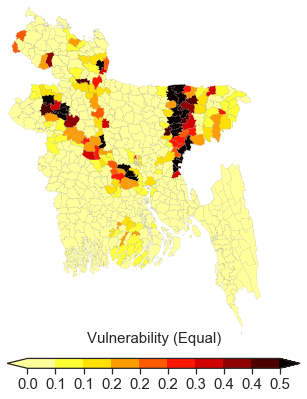

In [55]:


# Colormap
bounds = list(np.arange(0,0.5,0.05))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'hot_r', labloc='on',
                                                        boundaries=boundaries, extension='both')

# Mapping
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})

# Plotting
figlabel = 'Vulnerability (Equal)'
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
mapdata3.plot(ax=ax, column='POPU_FCST_RATIO', linewidth=0.1, edgecolor='grey', 
        cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)  
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",
                 loc='lower left',
                 bbox_to_anchor=(0, -0.1, 2.5, 1),
                 bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,
                                 boundaries=boundaries,
                                 extend='both',
                                 extendfrac=0.08,
                                 ticks = ticks,
                                 spacing='uniform',
                                 orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], 
                        fontname='arial', fontsize=15)
cbar.set_label(figlabel, labelpad=-60, 
               fontname='arial', fontsize=15, 
               horizontalalignment='center')
plt.show()

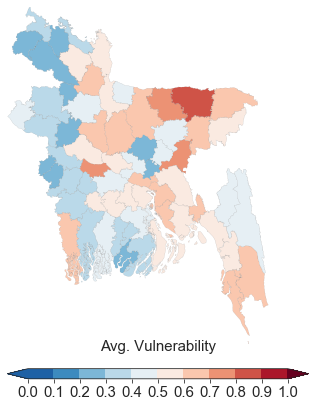

In [36]:
# Colormap
bounds = list(np.arange(0,1.1,0.1))
boundaries = [0]+bounds+[1]
cmap, norm, vmin, vmax, ticks, boundaries = fhv.cbarpam(bounds, 'RdBu_r', labloc='on',
                                                        boundaries=boundaries, extension='both')
# Mapping
sns.set_style("white", {'axes.linewidth': 1, 'grid.color': 'black'})
# Plotting
figlabel = 'Avg. Vulnerability'
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(4,5), facecolor='w')
ax.set_axis_off()
ax.set_aspect('equal')
ax.axis(lims)
mapdata2.plot(ax=ax, column='AVG_VULN_SOVI_INUN', linewidth=0.1, edgecolor='grey',cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)  
plt.tight_layout()
# Colorbar
cax = inset_axes(ax, width="46%", height="3%",loc='lower left',bbox_to_anchor=(0, -0.1, 2.5, 1),bbox_transform=ax.transAxes,borderpad=0)
cbar = mpl.colorbar.ColorbarBase(cax, cmap=cmap, norm=norm,boundaries=boundaries,extend='both',extendfrac=0.08,ticks = ticks,spacing='uniform',orientation='horizontal')
cbar.ax.set_xticklabels(['%.1f'%lb for lb in np.array(bounds)], fontname='arial', fontsize=15)
cbar.set_label(figlabel, labelpad=-60, fontname='arial', fontsize=15, horizontalalignment='center')
plt.show()

### Load 2017 flood damage records

In [56]:
damage = pd.read_hdf('./data/impact.hdf',key='data')
damage_raw = damage.copy(); damage_raw['PAFFCPOPU'] /= 100;
damage_table = pd.read_hdf('./data/impact_table.hdf', key='table')
name_MinMax = damage_table.loc[damage_table['Normalization'] == 'MinMax','Name']
if len(name_MinMax) > 0:
    damage[name_MinMax] = MinMaxScaler().fit_transform(damage[name_MinMax])
name_Quantile = damage_table.loc[damage_table['Normalization'] == 'Quantile','Name']
if len(name_Quantile) > 0:
    damage[name_Quantile] = QuantileTransformer(n_quantiles=10).fit_transform(damage[name_Quantile])

In [57]:
damage

,PAFFCPOPU,PDISPPOPU,NDEATH,NDAMGHOUS,DAMGROAD,DAMGCLAND,NAFFCINST,NDAMGTUBE,NTRAUMA,NDIARRHEA,NODIEASE
ADM2_PCODE,,,,,,,,,,,
1004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2012,0.001906,0.000000,0.000000,0.145319,0.671576,0.266061,0.335043,0.000000,0.882908,0.000000,0.000000
2013,0.003653,0.011619,0.000000,0.294004,0.786486,0.121449,0.453216,0.451204,0.000000,0.164303,0.361789
2019,0.037319,0.000000,0.066667,0.224529,0.894518,0.356334,0.000000,0.000000,0.895964,0.447761,0.000000
2084,0.077815,0.000000,0.000000,0.420373,0.350538,0.338146,0.000000,0.000000,0.000000,0.000000,0.000000
3026,0.024138,0.000000,0.000000,0.647554,0.257937,0.188378,0.686080,0.000000,0.000000,0.416021,0.886634
3029,0.041290,0.000000,0.000000,0.236141,0.257937,0.304001,0.509137,0.000000,0.000000,0.325683,0.752280
3039,0.652851,0.000000,0.600000,0.768004,0.915690,0.902298,1.000000,0.915719,0.876298,1.000000,0.952139
3054,0.012704,0.000734,0.000000,0.000000,0.317460,0.184648,0.000000,0.337895,0.000000,0.310929,0.738358


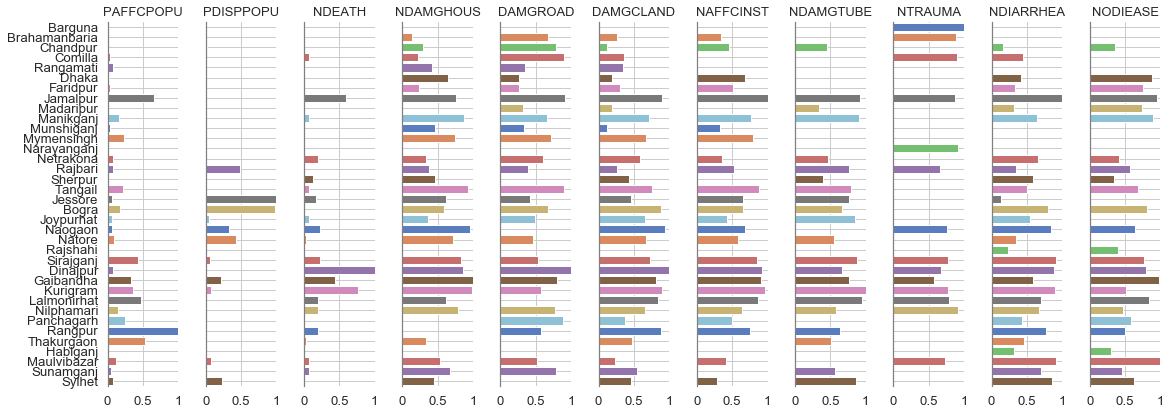

In [75]:
# Temprary data and Seaborn setting
temp = damage.copy().reset_index()
# temp = temp[temp.columns[:5]]
temp.index.name = 'Group'
temp = temp.merge(shape2[['ADM2_EN','ADM2_PCODE']], how='inner', left_on='ADM2_PCODE',right_on='ADM2_PCODE')

# PairGrid plots
sns.set(style="white", font_scale=1.2)
g = sns.PairGrid(temp, x_vars=temp.columns[1:-1], y_vars=['ADM2_EN'],
                height=6, aspect=.25)
g.map(sns.barplot, palette='muted')

# Same x axis limits on all columns and add better labels
g.set(xlim=[0, 1], xticks=[0,0.5,1], xticklabels=[0, 0.5, 1], xlabel='',
      ylabel="", yticklabels=temp['ADM2_EN'])

# Title and Grids
for ax, title in zip(g.axes.flat, temp.columns[1:]):
    # Title (Group name)
    ax.set_title(title, fontfamily='sans-serif', fontsize=13)
    # Make the grid horizontal instead of vertical
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)
    ax.spines['left'].set_color('grey')

# Remove axis lines
sns.despine(left=False, bottom=True)
plt.tight_layout()
plt.show()

# Save a figure
if False:
    fn_save = './figures/Vulnerability_comparison_'+method+'.png'
    g.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)

In [76]:



temp

,ADM2_PCODE,PAFFCPOPU,PDISPPOPU,NDEATH,NDAMGHOUS,DAMGROAD,DAMGCLAND,NAFFCINST,NDAMGTUBE,NTRAUMA,NDIARRHEA,NODIEASE,ADM2_EN
0,1004,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,Barguna
1,2012,0.001906,0.000000,0.000000,0.145319,0.671576,0.266061,0.335043,0.000000,0.882908,0.000000,0.000000,Brahamanbaria
2,2013,0.003653,0.011619,0.000000,0.294004,0.786486,0.121449,0.453216,0.451204,0.000000,0.164303,0.361789,Chandpur
3,2019,0.037319,0.000000,0.066667,0.224529,0.894518,0.356334,0.000000,0.000000,0.895964,0.447761,0.000000,Comilla
4,2084,0.077815,0.000000,0.000000,0.420373,0.350538,0.338146,0.000000,0.000000,0.000000,0.000000,0.000000,Rangamati
5,3026,0.024138,0.000000,0.000000,0.647554,0.257937,0.188378,0.686080,0.000000,0.000000,0.416021,0.886634,Dhaka
6,3029,0.041290,0.000000,0.000000,0.236141,0.257937,0.304001,0.509137,0.000000,0.000000,0.325683,0.752280,Faridpur
7,3039,0.652851,0.000000,0.600000,0.768004,0.915690,0.902298,1.000000,0.915719,0.876298,1.000000,0.952139,Jamalpur
8,3054,0.012704,0.000734,0.000000,0.000000,0.317460,0.184648,0.000000,0.337895,0.000000,0.310929,0.738358,Madaripur
9,3056,0.154836,0.000000,0.066667,0.879070,0.661668,0.712926,0.767865,0.903109,0.000000,0.647424,0.898960,Manikganj
